# Prepare Training Data

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/opt/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
CATEGORIES = ['waterways', 'fieldborders', 'terraces', 'wsb']
CLASS_DICT = {1: 'waterways', 2: 'fieldborders', 3: 'terraces', 4: 'wsb'}
NUM_CLASSES = 4

epoch = 100

IMAGE_H = 256
IMAGE_W = 256

JPG_NAME = 'jpg'

In [2]:
from numpy.random import seed
seed(98052)
from tensorflow import set_random_seed
set_random_seed(98052)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Configurations

In [4]:
class LOLConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 256
    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # COCO has 80 classes
    
config = LOLConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    5
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_PO

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Helper Function

In [6]:
def generate_mask_path(mask_dir, filename):
    fn_img, ext = os.path.splitext(os.path.basename(filename))
    mask_endings = [x for x in CATEGORIES if x != fn_img.split('_')[0]]
    mask_path = [os.path.join(mask_dir, filename)]
    for ending in mask_endings:
        mask_path.append( os.path.join(mask_dir, fn_img + '_'+ ending + '.jpg'))
    return mask_path

## LOL Dataset

In [7]:
class LolDataset(utils.Dataset):
    
    def load_LOL(self, datasetdir):
        
        for i in range(NUM_CLASSES):
            self.add_class("shapes", i, CLASS_DICT[i+1] )
        
        image_dir = os.path.join(datasetdir, JPG_NAME)
        mask_dir = os.path.join(datasetdir, 'polygon')
        
        image_names = next(os.walk(image_dir))[2]
        for i in range(len(image_names)):
            self.add_image("shapes", image_id = i,
                    path=os.path.join(image_dir, image_names[i]),
                    mask_path = generate_mask_path(mask_dir, image_names[i]),
                    width=IMAGE_W,
                    height=IMAGE_H)
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        image_path = info['path']
        image_BGR = cv2.imread(image_path)
        image = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask_path = info['mask_path']
        valid_mask = []
        for _mask_path in mask_path:
            _mask = cv2.imread(_mask_path, 0)
            
            if _mask.max() == _mask.min():
                pass
            else:
                valid_mask.append(_mask_path)
             
        count = len(valid_mask)
        mask = np.zeros([info['height'], info['width'], count], 'uint8')
        shapes = []
        for i in range(count):
            img_array = cv2.imread(valid_mask[i], 0)
            (thresh, im_bw) = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            mask_array = (img_array < thresh).astype('uint8')
            mask[:, :, i:i+1] = np.expand_dims(mask_array, axis=2)
            fn_img, ext = os.path.splitext(valid_mask[i])

            if fn_img.split('_')[-1] == 'merged':
                shapes.append(fn_img.split('/')[-1].split('_')[0])
            else:
                shapes.append(fn_img.split('_')[-1])
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s) for s in shapes])
        
        return mask, class_ids

In [8]:
train_dir = '/data/a/LOLRaw/data/processed_large/fourclasses/train_aug'
val_dir = '/data/a/LOLRaw/data/processed_large/fourclasses/test'

In [9]:
dataset_train = LolDataset()
dataset_train.load_LOL(train_dir)
dataset_train.prepare()

In [10]:
dataset_val = LolDataset()
dataset_val.load_LOL(val_dir)
dataset_val.prepare()

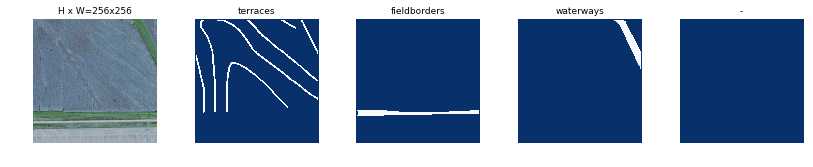

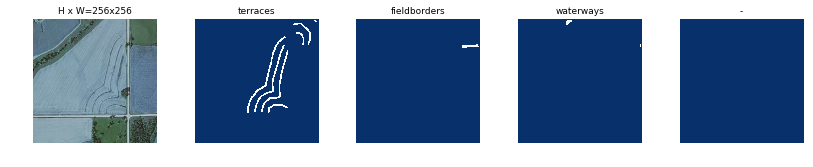

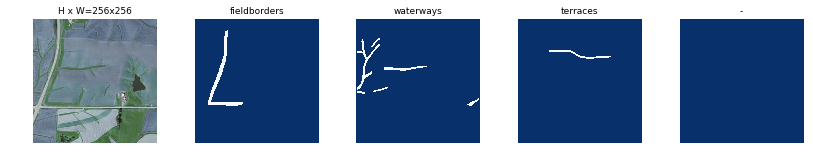

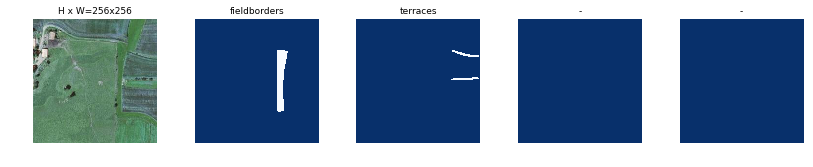

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=0.01, 
            epochs=300, 
            layers='all')


Starting at epoch 0. LR=0.01

Checkpoint Path: /home/tinzha/Projects/LandOLakes/logs/coco20180327T1729/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

/opt/anaconda3/lib/python3.5/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/150
 204/1000 [=====>........................] - ETA: 3:45 - loss: 2.9173 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.6511 - mrcnn_class_loss: 0.1491 - mrcnn_bbox_loss: 0.8001 - mrcnn_mask_loss: 0.2666

In [16]:
# # Fine tune all layers
# # Passing layers="all" trains all layers. You can also 
# # pass a regular expression to select which layers to
# # train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

In [17]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(LOLConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                             "mrcnn_bbox", "mrcnn_mask"])

# model_path = '/home/tinzha/Projects/LandOLakes/logs/coco20180312T2235/mask_rcnn_coco_0130.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
image_id

In [ ]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 13
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
def jaccard_coef(y_true, y_pred):
    intersec = y_true*y_pred
    union = np.logical_or(y_true, y_pred).astype(int)
    if intersec.sum() == 0:
        jac_coef = 0
    else:
        jac_coef = intersec.sum()/union.sum()
    return jac_coef

In [ ]:
def jac_per_image(image_id):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    jac = []
    jac_dict = {}
    for i in range(len(gt_class_id)):    
#         print (i)
        index = np.where(r['class_ids'] == gt_class_id[i])
        masks_pred = np.zeros((256,256,len(index[0])))
        for ind in range(len(index[0])):
            masks_pred[:,:,ind] = r['masks'][:,:,index[0][ind]]
        a = masks_pred.sum(axis = -1)
        b = gt_mask[:,:,i]
        jac.append(jaccard_coef(a,b))
        jac_dict[i] = jac
#         print (jaccard_coef(a, b))
    mean_jac = np.mean(jac)
    
#     print (mean_jac)
    
    return(jac_dict, mean_jac)
    

In [ ]:
r['masks'].shape, masks_pred.shape

In [ ]:
print (ind)
masks_pred[:,:,ind]

In [ ]:
index

In [ ]:
jac = []
for i in range(len(gt_class_id)):    
    print (i)
    index = np.where(r['class_ids'] == gt_class_id[i])
    print (index)
    masks_pred = np.zeros((256,256,len(index[0])))
    for ind in range(len(index[0])):
        print (ind)
        masks_pred[:,:,ind] = r['masks'][:,:,index[0][ind]]
    a = masks_pred.sum(axis = -1)
    b = gt_mask[:,:,i]
    jac.append(jaccard_coef(a,b))
    print (jaccard_coef(a, b))

print (np.mean(jac))
#     print (index)
#     print (dataset_train.class_names[index[0]])
    # obtain the area of mask
    
    

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10) # change the number of images
APs = []
jac = []
for image_id in dataset_val.image_ids:
    print (image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
    # compute jaccard
    jac_dict, jac_per_img = jac_per_image(image_id)
    jac.append(jac_per_img)
    
print("mAP: ", np.mean(APs))
print ("jac: ", np.mean(jac))

## check on the train images

In [ ]:
image_id = 0
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

## Evaluation on the selected images

In [ ]:
sample_img_names = ['waterways_610_4109150_merged.jpg', 'waterways_1053_4109150_merged.jpg', 'waterways_2026_4109150_merged.jpg',
                   'waterways_1457_4109210_merged.jpg','waterways_1282_4109150_merged.jpg', 'wsb_14_4109150_merged.jpg',
                   'wsb_31_4109150_merged.jpg', 'wsb_123_4109150_merged.jpg', 'wsb_563_4109150_merged.jpg',
                    'wsb_15_4109150_merged.jpg']

In [ ]:
sample_img_ids = []
for sample_img in sample_img_names:
    for i in range(len(dataset_val.image_info)):
        if dataset_val.image_info[i]['path'].split('/')[-1] == sample_img:
            sample_img_ids.append(dataset_val.image_info[i]['id'])

print (sample_img_ids)

In [ ]:
APs = []
for image_id in sample_img_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

### plot each image

In [ ]:
image_id = sample_img_ids[0]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[1]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[2]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[3]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[4]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[5]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[6]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[7]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[8]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
image_id = sample_img_ids[9]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## metrics

In [ ]:
g_matrix = r['masks'][:,:,0:1]

In [ ]:
d_matrix = gt_mask

In [ ]:
g_matrix.shape, d_matrix.shape

In [ ]:
detect_area = int(d_matrix.sum())
g_area = int(g_matrix.sum())

In [ ]:
inter_area = (d_matrix * g_matrix).sum()

In [ ]:
precision = inter_area/detect_area
recall = inter_area/g_area
print (precision)
print (recall)

In [ ]:
# visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
#                         overlaps, dataset_train.class_names)